### Building CHatbots with multiple tools 

#### AIM
Create a chatbot with tool capabilities from arxiv , wikipedia and some function

In [30]:
from langchain_community.tools import ArxivQueryRun , WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper , ArxivAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph , START , END
from langgraph.prebuilt import ToolNode , tools_condition
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages
from IPython.display import Image , display
from langchain_core.messages import HumanMessage , AIMessage , SystemMessage , AnyMessage
from pprint import PrettyPrinter
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [8]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2 , doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [15]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1 , doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
print(wiki.name)

wikipedia


In [16]:
wiki.invoke("What is Machine Learning?")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [19]:
#Tavily Search Tool
tavily = TavilySearchResults()


C:\Users\User\AppData\Local\Temp\ipykernel_12092\3074595494.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [20]:
tavily.invoke("Provide me the recent job market news in United States")

[{'title': "Job Market's Effect on the Economy | U.S. Bank",
  'url': 'https://www.usbank.com/investing/financial-perspectives/market-news/effect-of-job-market-on-the-economy.html',
  'content': 'Job openings data suggest the labor market is moving toward a more restrained setting. As of December 2025, job openings totaled 6.5 million while unemployed persons were 7.5 million, a gap of nearly one million—a notable shift from the earlier “worker shortage” era, in the wake of the recent pandemic. 2 The same report shows hires and total separations were roughly 5.3 million each, which is consistent with a “freeze” dynamic in the labor market rather than expansion. 2 [...] That stronger headline arrives after a softer finish to last year. In December, the U.S. economy added 48,000 jobs, and the unemployment rate sat at 4.4%, reflecting slower momentum than earlier in 2025. 1 January’s improvement helps reinforce that the labor market is still moving forward, even if the pace remains uneven

In [21]:
tools = [arxiv,wiki,tavily]

In [26]:
#Initialise my LLM Model
llm = ChatGroq(model="qwen/qwen3-32b" , reasoning_format="hidden")
llm_with_tools = llm.bind_tools(tools)

In [27]:
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI news?")])

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '89jgkk71t', 'function': {'arguments': '{"query":"recent AI news"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 265, 'prompt_tokens': 400, 'total_tokens': 665, 'completion_time': 0.836240188, 'completion_tokens_details': {'reasoning_tokens': 236}, 'prompt_time': 0.01965805, 'prompt_tokens_details': None, 'queue_time': 0.038087667, 'total_time': 0.855898238}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_78ac7f3229', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c6dd3-3670-7952-b0fb-e452b215f8ef-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'recent AI news'}, 'id': '89jgkk71t', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 400, 'output_tokens': 265, 'total_tokens': 665, 'output_token_details': {'reasoning': 2

In [31]:
class State(TypedDict):
    messages:Annotated[list[AnyMessage], add_messages]

In [32]:
def tool_calling_llm(state:State):
    response = llm_with_tools.invoke(state["messages"])
    return {"messages":response}

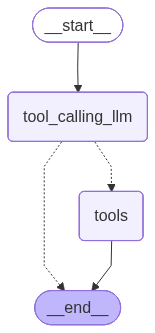

In [33]:
builder = StateGraph(State)

builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START , "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools",END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
messages = graph.invoke({"messages": HumanMessage(content=f"What is Machine Learning?")})
print(messages["messages"][-1].content)

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML fi
